In [1]:
from sklearn.feature_extraction import image as image_extractor
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import SparseCoder
from skimage import io
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
import csv
import numpy as np
import distutils
from distutils import util
from scipy import fftpack
import math
import time
#import wavepy
import pandas as pd
import pdb
import pylab as pl
from IPython import display

from sklearn.utils import check_array, check_random_state, gen_even_slices, gen_batches
import itertools

import warnings
warnings.filterwarnings("ignore", message="The default value of batch_size will change from*")
warnings.filterwarnings("ignore", message="'n_iter' is deprecated in version*")

In [2]:
class MyMiniBatchDictionaryLearning(MiniBatchDictionaryLearning):
    def fit(self, X, y=None):
        """Fit the model from data in X.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training vector, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : Ignored
            Not used, present for API consistency by convention.
        Returns
        -------
        self : object
            Returns the instance itself.
        """
        
        pl.figure(figsize=(4.2, 4))
        self.diff_dict = []
        
        self._batch_size = self.batch_size
        if self.batch_size == "warn":
            warnings.warn(
                "The default value of batch_size will change from 3 to 256 in 1.3.",
                FutureWarning,
            )
            self._batch_size = 3

        X = self._validate_data(
            X, dtype=[np.float64, np.float32], order="C", copy=False
        )

        self._check_params(X)
        self._random_state = check_random_state(self.random_state)

        dictionary = self._initialize_dict(X, self._random_state)
        old_dict = dictionary.copy()

        if self.shuffle:
            X_train = X.copy()
            self._random_state.shuffle(X_train)
        else:
            X_train = X

        n_samples, n_features = X_train.shape

        if self.verbose:
            print("[dict_learning]")

        # Inner stats
        self._inner_stats = (
            np.zeros((self._n_components, self._n_components), dtype=X_train.dtype),
            np.zeros((n_features, self._n_components), dtype=X_train.dtype),
        )

        if self.max_iter is not None:

            # Attributes to monitor the convergence
            self._ewa_cost = None
            self._ewa_cost_min = None
            self._no_improvement = 0

            batches = gen_batches(n_samples, self._batch_size)
            batches = itertools.cycle(batches)
            n_steps_per_iter = int(np.ceil(n_samples / self._batch_size))
            n_steps = self.max_iter * n_steps_per_iter

            i = -1  # to allow max_iter = 0

            for i, batch in zip(range(n_steps), batches):
                X_batch = X_train[batch]

                batch_cost = self._minibatch_step(
                    X_batch, dictionary, self._random_state, i
                )

                if self._check_convergence(
                    X_batch, batch_cost, dictionary, old_dict, n_samples, i, n_steps
                ):
                    break

                # XXX callback param added for backward compat in #18975 but a common
                # unified callback API should be preferred
                if self.callback is not None:
                    self.callback(locals())

                self.diff_dict.append(np.linalg.norm(dictionary - old_dict, 'fro'))
                if(i%10 == 0):
                    print("step",i,", d_x:", self.diff_dict[-1])
                
                old_dict[:] = dictionary
                
                # plot the dictionary
                if ((i < plot_stop_at_x_dicts) and (i%plot_period == 0 or (i%plot_period_beginning == 0 and i < 18))):
                    plot_dict(dictionary.copy(), i, num_atoms_plot, patch_size[0])

            self.n_steps_ = i + 1
            self.n_iter_ = np.ceil(self.n_steps_ / n_steps_per_iter)
        else:
            # TODO remove this branch in 1.3
            if self.n_iter != "deprecated":
                warnings.warn(
                    "'n_iter' is deprecated in version 1.1 and will be removed"
                    " in version 1.3. Use 'max_iter' instead.",
                    FutureWarning,
                )
                n_iter = self.n_iter
            else:
                n_iter = 1000

            batches = gen_batches(n_samples, self._batch_size)
            batches = itertools.cycle(batches)

            for i, batch in zip(range(n_iter), batches):
                self._minibatch_step(X_train[batch], dictionary, self._random_state, i)

                trigger_verbose = self.verbose and i % ceil(100.0 / self.verbose) == 0
                if self.verbose > 10 or trigger_verbose:
                    print(f"{i} batches processed.")

                if self.callback is not None:
                    self.callback(locals())
                
                # plot the dictionary
                if ((i < plot_stop_at_x_dicts) and (i%plot_period == 0 or (i%plot_period_beginning == 0 and i < 18))):
                    plot_dict(dictionary.copy(), i, num_atoms_plot, patch_size[0])

            self.n_steps_ = n_iter
            self.n_iter_ = np.ceil(n_iter / int(np.ceil(n_samples / self._batch_size)))

        self.components_ = dictionary
        
        """
        plt.figure(figsize=(4.2, 4))
        plt.semilogy(np.array(self.diff_dict))
        plt.xlabel('iter')
        plt.ylabel('difference between dicts')
        plt.show()
        """

        return self

In [3]:
"""
Plot learned dictionary
"""
def plot_dict(dicti, iteration, num_atoms_plot, patch_size):    
    for i, comp in enumerate(dicti[:num_atoms_plot]):
        pl.subplot(int(num_atoms_plot/10), 10, i + 1)
        atom = comp.reshape(patch_size,patch_size,-1)
        pl.imshow(atom[:,:,0], cmap=pl.cm.gray_r,
               interpolation='nearest')
        pl.xticks(())
        pl.yticks(())
    pl.suptitle('Dictionary learned. iter'+str(iteration)+'\n', fontsize=16)
    pl.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    display.clear_output(wait=True) # wait=True doesn't clear the output until new output is available to replace it
    display.display(pl.gcf()) # get current figure (if there is none, one is created)

In [4]:
"""
Generate gradient (Gx) for an image
"""
from scipy import ndimage
def gen_Gx(image, C_scale=1):
    return ndimage.sobel(image, axis=0).astype('float32') / C_scale

### Set properties, choose image

In [5]:
import numpy as np
import scipy as sp
from PIL import Image, ImageOps

use_gradient = True
use_racoon_image = True
patch_size = (13,13)

# dict plotting
num_atoms_plot = 50
plot_period = 24
plot_period_beginning = 5 # if plot_period == 1, then this is effectless
plot_stop_at_x_dicts = 5000 # put eg 5000 if all dicts should be plotted

if use_racoon_image:
    try:  # SciPy >= 0.16 have face in misc
        from scipy.misc import face
        face = face(gray=True)
    except ImportError:
        face = sp.face(gray=True)

else:
    face = np.asarray(ImageOps.grayscale(Image.open("frame_00000561_right_half.png")))
    
    # our code differs: image = io.imread("frame_00000561.png",as_gray=True).astype('float32')

# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.0

if use_racoon_image:
    # downsample for higher speed
    face = face[::4, ::4] + face[1::4, ::4] + face[::4, 1::4] + face[1::4, 1::4]
    face /= 4.0
    
height, width = face.shape

if use_gradient:
    face = gen_Gx(face, C_scale=8)
    sigma_noise = 0.01 # 0.075 for normal image (instead of gradient image)
else:
    sigma_noise = 0.075

    
# Distort the right half of the image
print("Distorting image...")
distorted = face.copy()
distorted[:, width // 2 :] += sigma_noise * np.random.randn(height, width // 2)

Distorting image...


In [6]:
"""
print(height, ' x ', width)
# plot histograms
_ = plt.hist(face.reshape(-1), bins=100)
plt.show()

_ = plt.hist(distorted.reshape(-1), bins=100)
plt.show()
"""

"\nprint(height, ' x ', width)\n# plot histograms\n_ = plt.hist(face.reshape(-1), bins=100)\nplt.show()\n\n_ = plt.hist(distorted.reshape(-1), bins=100)\nplt.show()\n"

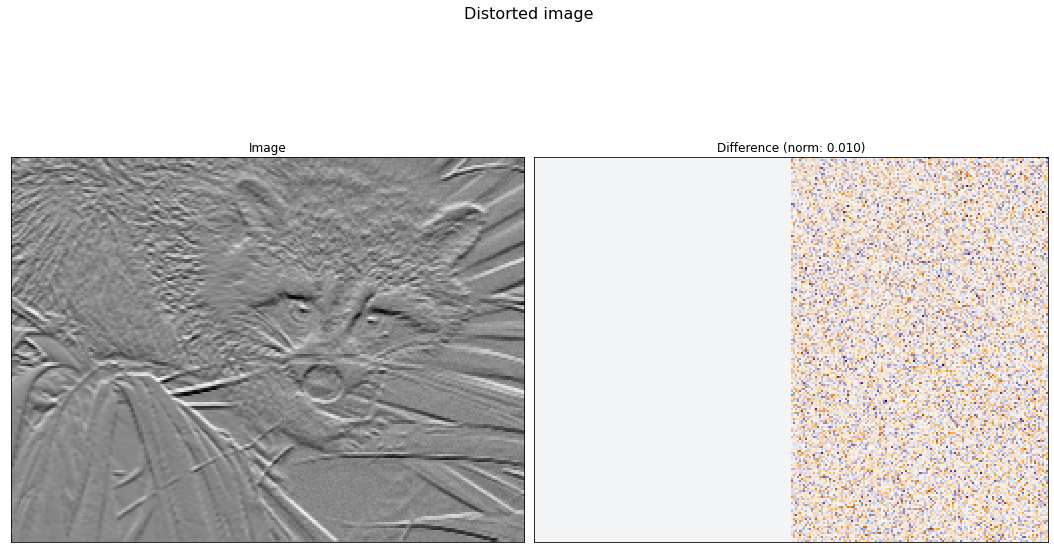

In [7]:
def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(15, 8.3))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image, cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title("Difference (norm: %.3f)" % np.sqrt(np.mean(difference**2)*2)) # *2 because only one half of the image is distorted
    plt.imshow(
        difference, cmap=plt.cm.PuOr, interpolation="nearest"
    )
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)


show_with_diff(distorted, face, "Distorted image")

In [8]:
from time import time

from sklearn.feature_extraction.image import extract_patches_2d

# Extract all reference patches from the left half of the image
print("Extracting reference patches...")
t0 = time()
data = extract_patches_2d(distorted[:, : width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)
print(f"{data.shape[0]} patches extracted in %.2fs." % (time() - t0))


Extracting reference patches...
20880 patches extracted in 0.08s.


In [9]:
from sklearn.decomposition import MiniBatchDictionaryLearning

print("Learning the dictionary...")
t0 = time()
dico = MyMiniBatchDictionaryLearning(
    # increase to 300 for higher quality results at the cost of slower
    # training times.
    n_components=50,
    batch_size=200,
    alpha=1.0,
    max_iter=10,
)
V = dico.fit(data).components_

Learning the dictionary...


KeyboardInterrupt: 

<Figure size 302.4x288 with 0 Axes>

In [ ]:
# plot convergence
plt.figure(figsize=(4.2, 4))
plt.semilogy(np.array(dico.diff_dict))
plt.xlabel('step')
plt.ylabel('difference between dicts')
plt.show()        

In [ ]:
# plotting from original racoon code
dt = time() - t0
print(f"{dico.n_iter_} iterations / {dico.n_steps_} steps in {dt:.2f}.")

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle(
    "Dictionary learned from face patches\n"
    + "Train time %.1fs on %d patches" % (dt, len(data)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

Extract noisy patches

In [ ]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

print("Extracting noisy patches... ")
t0 = 1.
data = extract_patches_2d(distorted[:, width // 2 :], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
#print("done in %.2fs." % (time() - t0))

transform_algorithms = [
    ("Orthogonal Matching Pursuit\n1 atom", "omp", {"transform_n_nonzero_coefs": 1}),
    ("Orthogonal Matching Pursuit\n10 atoms", "omp", {"transform_n_nonzero_coefs": 3}),
    ("Least-angle regression\n4 atoms", "lars", {"transform_n_nonzero_coefs": 4}),
    ("Thresholding\n alpha=0.1", "threshold", {"transform_alpha": 0.1}),
]

reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + "...")
    reconstructions[title] = face.copy()
    t0 = 1.
    dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    patches = np.dot(code, V)

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == "threshold":
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2 :] = reconstruct_from_patches_2d(
        patches, (height, width // 2)
    )
    #dt = time() - t0
    #print("done in %.2fs." % dt)
    show_with_diff(reconstructions[title], face, title + " (time: ")

plt.show()